In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.stats import poisson
import math
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import json
from datetime import date, timedelta
np.random.seed(seed=0)
plt.rcParams['text.usetex'] = True

plt.rcParams.update({'font.size': 16})
# plt.rcParams["font.family"] = "Times New Roman"
# sns.set_style("whitegrid", rc={'font.family': 'Times New Roman', 'font.size': 16})
sns.set_style("whitegrid", rc={'font.size': 16})

from constants import LOCATION_CHOOSEN, LOCATION_CHOOSEN_2, OUTPUT_DIR, DATA_CACHE_DIR, OPTIMAL_VALUES_FILE, STRINGENCY_BASED_GDP

- Susceptible (S): This should ideally be the total population minus the total cases. So, your calculation seems correct here. However, it's important to note that 'total_cases' includes both currently infected individuals and those who have recovered or died. Therefore, a more accurate calculation might be `df['S'] = df['population'] - df['total_cases']`.

- Infected (I): This should be the current active cases, not the total cases. You might need to calculate this as `df['I'] = df['total_cases'] - df['total_deaths'] - df['people_fully_vaccinated']`.

- Recovered (R): This should include people who have recovered from the disease and those who are vaccinated. If your dataset includes a 'total_recovered' column, you could use that. If not, you might need to estimate it. You could potentially use `df['R'] = df['people_fully_vaccinated'] + df['total_deaths']` (assuming that all who are not currently infected and have not been vaccinated have recovered).

Please note that these are just suggestions and the actual implementation might vary based on the specific details and assumptions of your model. Also, this model does not take into account the natural birth and death in the population. It's a simple model and might not fully capture the complexities of an actual outbreak.

In [2]:
data_path = os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv")
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    df = pd.read_excel("owid-covid-data.xlsx")
    df = df.loc[df['iso_code'] == LOCATION_CHOOSEN]
    df.to_csv(data_path, index=False)

In [3]:
df.columns

Index(['date', 'stringency_index', 'total_cases', 'total_deaths',
       'total_vaccinations', 'population', 'people_fully_vaccinated',
       'gdp_normalized', 'gdp_normalized_modelled'],
      dtype='object')

In [4]:
start_date = date(2020, 2, 10)
end_date = date(2022, 11, 1)
delta = timedelta(days=1)

worldometers_dates = []
worldometers_total_cases = []
worldometers_total_recovered = []

while start_date <= end_date:
    date_str = start_date.strftime("%Y%m%d")
    data_path_worldometer = os.path.join(DATA_CACHE_DIR, "worldometer", date_str + ".csv")
    if os.path.exists(data_path_worldometer):
        worldometer_df = pd.read_csv(data_path_worldometer)
        worldometer_df.columns = ['country' if col.startswith('Country') else col for col in worldometer_df.columns]
        worldometer_df.columns = worldometer_df.columns.str.lower().str.replace(' ', '')
        date_data = ""
        total_cases = 0
        total_recovered = 0
        worldometer_df_specified_location = worldometer_df.loc[(worldometer_df["country"].str.lower() == LOCATION_CHOOSEN_2.lower())]
        date_data = date_str[:4] + "-" + date_str[4:6] + "-" + date_str[6:]
        total_cases = 0.0 if math.isnan(worldometer_df_specified_location["totalcases"].item()) else worldometer_df_specified_location["totalcases"].item()
        total_recovered = 0.0 if math.isnan(worldometer_df_specified_location["totalrecovered"].item()) else worldometer_df_specified_location["totalrecovered"].item()
        print(date_data, total_cases, total_recovered, type(total_recovered), math.isnan(total_recovered))
        worldometers_dates.append(date_data)
        worldometers_total_cases.append(total_cases)
        worldometers_total_recovered.append(total_recovered)
    else:
        print(data_path_worldometer, "DOES NOT EXIST -- COLLECT DATA MANUALLY")
    start_date += delta

2020-02-10 3 0.0 <class 'float'> False
2020-02-11 3 0.0 <class 'float'> False
2020-02-12 3 0.0 <class 'float'> False
2020-02-13 5 1.0 <class 'float'> False
2020-02-14 3 1.0 <class 'float'> False
2020-02-15 3 3.0 <class 'float'> False
2020-02-16 3 3.0 <class 'float'> False
2020-02-17 3 3.0 <class 'float'> False
2020-02-18 3 3.0 <class 'float'> False
2020-02-19 3 3.0 <class 'float'> False
2020-02-20 3 3.0 <class 'float'> False
2020-02-21 3 3.0 <class 'float'> False
2020-02-22 3 3.0 <class 'float'> False
2020-02-23 3 3.0 <class 'float'> False
2020-02-24 3 3.0 <class 'float'> False
2020-02-25 3 3.0 <class 'float'> False
2020-02-26 3 3.0 <class 'float'> False
2020-02-27 3 3.0 <class 'float'> False
2020-02-28 3 3.0 <class 'float'> False
2020-02-29 3 3.0 <class 'float'> False
2020-03-01 3 3.0 <class 'float'> False
2020-03-02 6 3.0 <class 'float'> False
2020-03-03 6 3.0 <class 'float'> False
2020-03-04 28 3.0 <class 'float'> False
2020-03-05 30 3.0 <class 'float'> False
2020-03-06 30 3.0 <clas

2020-09-01 3694878 2840040.0 <class 'float'> False
2020-09-02 3773483 2902096.0 <class 'float'> False
2020-09-03 3853406 2970492.0 <class 'float'> False
2020-09-04 3936747 3037151.0 <class 'float'> False
2020-09-05 4023179 3107223.0 <class 'float'> False
2020-09-06 4114773 3180999.0 <class 'float'> False
2020-09-07 4208645 3250429.0 <class 'float'> False
2020-09-08 4280422 3323950.0 <class 'float'> False
2020-09-09 4374314 3398844.0 <class 'float'> False
2020-09-10 4465863 3471783.0 <class 'float'> False
2020-09-11 4568770 3544794.0 <class 'float'> False
2020-09-12 4663930 3624375.0 <class 'float'> False
2020-09-13 4754356 3702595.0 <class 'float'> False
2020-09-14 4846427 3780107.0 <class 'float'> False
2020-09-15 4930236 3859399.0 <class 'float'> False
2020-09-16 5025043 3942360.0 <class 'float'> False
2020-09-17 5212686 4109828.0 <class 'float'> False
2020-09-18 5214677 4112551.0 <class 'float'> False
2020-09-19 5351723 4249648.0 <class 'float'> False
2020-09-20 5400619 4303043.0 <c

2021-02-09 10847790 10546905.0 <class 'float'> False
2021-02-10 10858300 10559604.0 <class 'float'> False
2021-02-11 10872664 10572969.0 <class 'float'> False
2021-02-12 10880413 10587351.0 <class 'float'> False
2021-02-13 10892550 10598709.0 <class 'float'> False
2021-02-14 10904940 10611731.0 <class 'float'> False
2021-02-15 10916589 10621220.0 <class 'float'> False
2021-02-16 10925710 10633025.0 <class 'float'> False
2021-02-17 10937320 10644858.0 <class 'float'> False
2021-02-18 10950201 10656845.0 <class 'float'> False
2021-02-19 10963394 10667741.0 <class 'float'> False
2021-02-20 10977387 10678048.0 <class 'float'> False
2021-02-21 11005071 10697014.0 <class 'float'> False
2021-02-22 11005071 10697014.0 <class 'float'> False
2021-02-23 11016434 10712665.0 <class 'float'> False
2021-02-24 11030176 10726702.0 <class 'float'> False
2021-02-25 11046914 10738501.0 <class 'float'> False
2021-02-26 11063491 10750680.0 <class 'float'> False
2021-02-27 11079979 10763451.0 <class 'float'>

2021-08-21 32393286 31597982.0 <class 'float'> False
2021-08-22 32424234 31636469.0 <class 'float'> False
2021-08-23 32449306 31680626.0 <class 'float'> False
2021-08-24 32511369 31746625.0 <class 'float'> False
2021-08-25 32512366 31754281.0 <class 'float'> False
2021-08-26 32558530 31788440.0 <class 'float'> False
2021-08-27 32603188 31821428.0 <class 'float'> False
2021-08-28 32649130 31845313.0 <class 'float'> False
2021-08-29 32695030 31888642.0 <class 'float'> False
2021-08-30 32737939 31923405.0 <class 'float'> False
2021-08-31 32768880 31959680.0 <class 'float'> False
2021-09-01 32810892 31993644.0 <class 'float'> False
2021-09-02 32857937 32028825.0 <class 'float'> False
2021-09-03 32903289 32063616.0 <class 'float'> False
2021-09-04 32945907 32100001.0 <class 'float'> False
2021-09-05 32988673 32138092.0 <class 'float'> False
2021-09-06 33027621 32181995.0 <class 'float'> False
2021-09-07 33058843 32224937.0 <class 'float'> False
2021-09-08 33096718 32264051.0 <class 'float'>

2022-02-28 42924130 42307686.0 <class 'float'> False
2022-03-01 42931045 42324550.0 <class 'float'> False
2022-03-02 42944761 42343229.0 <class 'float'> False
2022-03-03 42945160 42353620.0 <class 'float'> False
2022-03-04 42951556 42367070.0 <class 'float'> False
2022-03-05 42957477 42378721.0 <class 'float'> False
2022-03-06 42962953 42388475.0 <class 'float'> False
2022-03-07 42967077 42388475.0 <class 'float'> False
2022-03-08 42971308 42406150.0 <class 'float'> False
2022-03-09 42975883 42413566.0 <class 'float'> False
2022-03-10 42980067 42420120.0 <class 'float'> False
2022-03-11 42984261 42426328.0 <class 'float'> False
2022-03-12 42987875 42431513.0 <class 'float'> False
2022-03-13 42990991 42437072.0 <class 'float'> False
2022-03-14 42993494 42441449.0 <class 'float'> False
2022-03-15 42996062 42446171.0 <class 'float'> False
2022-03-16 42998938 42450055.0 <class 'float'> False
2022-03-17 43001477 42454546.0 <class 'float'> False
2022-03-18 43004005 42458543.0 <class 'float'>

2022-09-06 44466862 43886496.0 <class 'float'> False
2022-09-07 44472241 43893590.0 <class 'float'> False
2022-09-08 44478636 43900204.0 <class 'float'> False
2022-09-09 44484729 43906972.0 <class 'float'> False
2022-09-10 44490283 43913294.0 <class 'float'> False
2022-09-11 44495359 43919264.0 <class 'float'> False
2022-09-12 44500580 43925239.0 <class 'float'> False
2022-09-13 44504949 43930417.0 <class 'float'> False
2022-09-14 44507882 43930417.0 <class 'float'> False
2022-09-15 44516479 43941840.0 <class 'float'> False
2022-09-16 44522777 43947756.0 <class 'float'> False
2022-09-17 44528524 43953374.0 <class 'float'> False
2022-09-18 44534188 43957929.0 <class 'float'> False
2022-09-19 44539046 43962664.0 <class 'float'> False
2022-09-20 44543089 43967340.0 <class 'float'> False
2022-09-21 44547599 43972980.0 <class 'float'> False
2022-09-22 44553042 43978271.0 <class 'float'> False
2022-09-23 44558425 43984695.0 <class 'float'> False
2022-09-24 44565874 43990414.0 <class 'float'>

In [5]:
worldometer_df = pd.DataFrame({"date": worldometers_dates, "active_cases": worldometers_total_cases, "total_recovered": worldometers_total_recovered})
# worldometer_df['date'] = pd.to_datetime(worldometer_df['date'])
display(worldometer_df)

,date,active_cases,total_recovered
0,2020-02-10,3,0.0
1,2020-02-11,3,0.0
2,2020-02-12,3,0.0
3,2020-02-13,5,1.0
4,2020-02-14,3,1.0
...,...,...,...
991,2022-10-28,44649088,44100691.0
992,2022-10-29,44650714,44102852.0
993,2022-10-30,44652266,44104933.0
994,2022-10-31,44653592,44106656.0


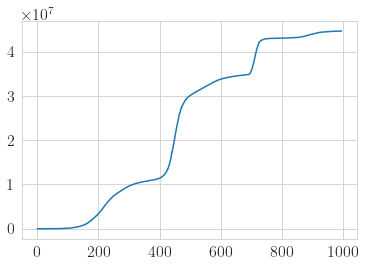

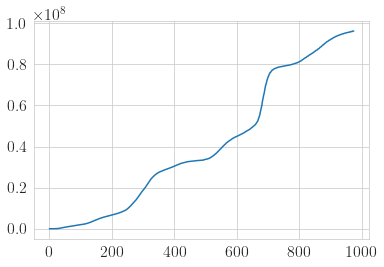

In [6]:
plt.plot(range(len(worldometer_df)), worldometer_df['active_cases'])
plt.figure()
plt.plot(range(len(df)), df['total_cases'])

In [7]:
result = pd.merge(df, worldometer_df, on="date")
df = result

In [8]:
print(df.columns)

Index(['date', 'stringency_index', 'total_cases', 'total_deaths',
       'total_vaccinations', 'population', 'people_fully_vaccinated',
       'gdp_normalized', 'gdp_normalized_modelled', 'active_cases',
       'total_recovered'],
      dtype='object')


In [9]:
df

,date,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated,gdp_normalized,gdp_normalized_modelled,active_cases,total_recovered
0,2020-03-01,11.11,73.0,1.0,45620.0,338289856.0,9669.0,95.576821,95.931488,3,3.0
1,2020-03-02,11.11,82.0,2.0,45620.0,338289856.0,9669.0,95.501304,95.931488,6,3.0
2,2020-03-03,11.11,100.0,2.0,45620.0,338289856.0,9669.0,95.425787,95.931488,6,3.0
3,2020-03-04,11.11,135.0,8.0,45620.0,338289856.0,9669.0,95.350270,95.931488,28,3.0
4,2020-03-05,20.37,186.0,11.0,45620.0,338289856.0,9669.0,95.274753,98.285172,30,3.0
...,...,...,...,...,...,...,...,...,...,...,...
971,2022-10-28,24.09,96175292.0,1059919.0,645210369.0,338289856.0,227841296.0,99.670068,98.993835,44649088,44100691.0
972,2022-10-29,24.09,96175292.0,1059919.0,645582174.0,338289856.0,227867880.0,99.671069,98.993835,44650714,44102852.0
973,2022-10-30,24.09,96175292.0,1059919.0,645776076.0,338289856.0,227882024.0,99.672071,98.993835,44652266,44104933.0
974,2022-10-31,24.09,96175292.0,1059919.0,646384492.0,338289856.0,227924209.0,99.673072,98.993835,44653592,44106656.0


In [10]:
df['date'] = pd.to_datetime(df['date'])

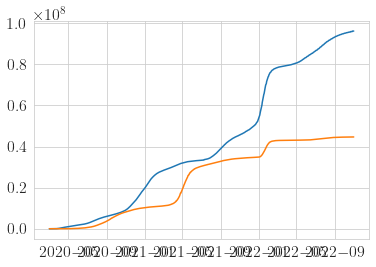

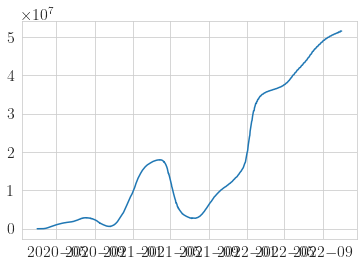

In [11]:
plt.plot(df['date'], df['total_cases'])
plt.plot(df['date'], df['active_cases'])

plt.figure()

plt.plot(df['date'], df['total_cases'] - df['active_cases'])

In [12]:
def detect_outlier(data):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [25, 75])
 
    # compute IRQ
    iqr = q3 - q1
 
    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
 
    outliers = [x for x in data if x <= lower_bound or x >= upper_bound]
 
    return outliers

In [13]:
print(df.columns)

Index(['date', 'stringency_index', 'total_cases', 'total_deaths',
       'total_vaccinations', 'population', 'people_fully_vaccinated',
       'gdp_normalized', 'gdp_normalized_modelled', 'active_cases',
       'total_recovered'],
      dtype='object')


## Simple SIR

In [14]:
# df['N'] = df['population']
# df['I'] = df['active_cases']
# df['R'] = df['total_recovered']
# df['S'] =  df['N'] - (df['I'] + df['R'])


# df['N'] = df['population']
# df['I'] = df['total_cases'] - df['total_recovered'] - df['total_deaths']
# df['R'] = df['total_recovered']
# df['S'] = df['N'] - df['I'] - df['R'] - df['people_fully_vaccinated']

# df['N'] = df['population']
# df['I'] = df['total_cases']
# df['R'] = df['total_recovered']
# df['S'] = df['N'] - (df['I'] + df['R'])

# df['N'] = df['population']
# df['I'] = df['total_cases']
# df['R'] = df['total_vaccinations']
# df['S'] = df['N'] - (df['I'] + df['R'])

df['N'] = df['population']
df['S'] = df['population'] - (df['total_cases'] + df['people_fully_vaccinated'])
df['I'] = df['total_cases']
df['R'] = df['people_fully_vaccinated']

print(detect_outlier(df['S']), detect_outlier(df['I']), detect_outlier(df['R']))

[] [] []


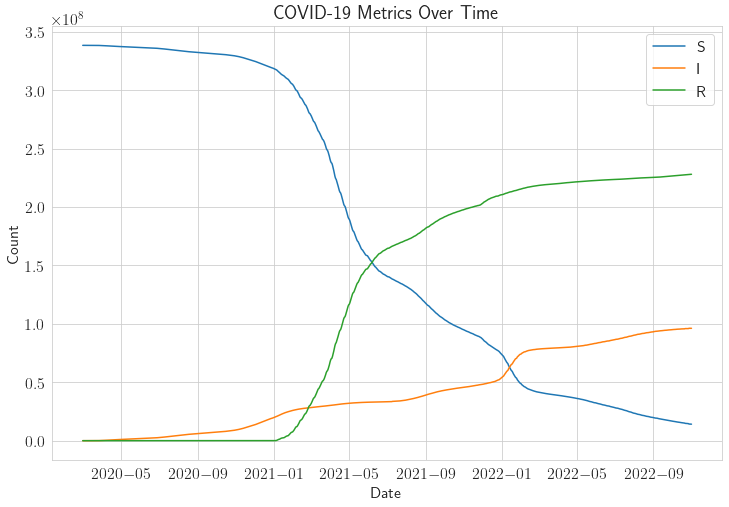

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['S'], label='S')
plt.plot(df['date'], df['I'], label='I')
plt.plot(df['date'], df['R'], label='R')
plt.title('COVID-19 Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "metrics_over_time_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [16]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def compute_cost(data, predictions):
    # mse
    return np.square(data - predictions).mean()

def compute_cost(data, predictions):
    # mae
    return np.abs(data - predictions).mean()

def compute_cost(data, predictions, delta=1.0):
    # Huber loss
    residual = np.abs(data - predictions)
    condition = residual < delta
    squared_loss = 0.5 * np.square(residual)
    linear_loss = delta * (residual - 0.5 * delta)
    return np.where(condition, squared_loss, linear_loss).mean()

def compute_cost(data, predictions):
    # Relative Root Mean Squared Error
    residual = data - predictions
    root_mean_squared_error = np.sqrt(np.mean(np.square(residual)))
    mean_data = np.mean(data)
    return root_mean_squared_error / mean_data

# def compute_cost(data, predictions):
#     # mse
#     mse = np.square(data - predictions).mean()
#     # normalize mse to [0, 1] range
#     normalized_mse = mse / (np.max(data)**2)
#     return normalized_mse

def integrate_system(params, y0, t, N):
    beta, gamma = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma))
    return result

def objective_function(params, y0, t, N):
    predictions = integrate_system(params, y0, t, N)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [17]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma = 0.2, 1./10 
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

optimal_beta: 0.08594727422538355 optimal_gamma: 0.05192135475988757
optimal_beta/optimal_gamma: 1.6553357404260778


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


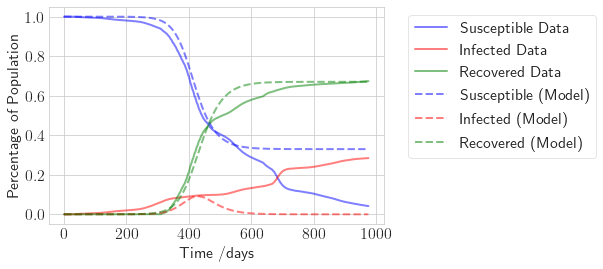

cost_without_lockdown: 1.5902477953777476


In [18]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma]
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma))
S, I, R = ret.T

plt.figure()
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time /days')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_fit_without_lockdown_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

cost_without_lockdown = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost_without_lockdown: {cost_without_lockdown}")

In [19]:
r0 = optimal_beta/optimal_gamma

df["S_modelled_without_lockdown"] = S
df["I_modelled_without_lockdown"] = I
df["R_modelled_without_lockdown"] = R
df["r_eff_actual_without_lockdown"] = r0 * df["S"]/df["N"]
df["r_eff_modelled_without_lockdown"] = r0 * df["S_modelled_without_lockdown"]/df["N"]

## SIRV Model

[] [] []


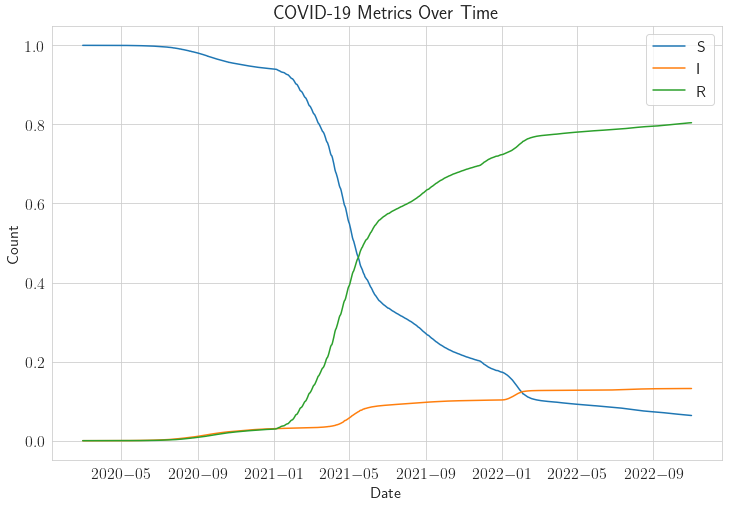

In [20]:
df['N'] = df['population']
df['I'] = df['active_cases']
df['R'] = df['total_recovered'] + df['people_fully_vaccinated']
df['S'] =  df['population'] - (df['I'] + df['R'])

print(detect_outlier(df['S']), detect_outlier(df['I']), detect_outlier(df['R']))

plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['S']/df['N'], label='S')
plt.plot(df['date'], df['I']/df['N'], label='I')
plt.plot(df['date'], df['R']/df['N'], label='R')
plt.title('COVID-19 Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "metrics_over_time_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [21]:
def deriv(y, t, N, beta, gamma, nu):
    S, I, R = y
    dSdt = -beta * S * I / N - nu * S
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I + nu * S
    return dSdt, dIdt, dRdt

def integrate_system(params, y0, t, N):
    beta, gamma, nu = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma, nu))
    return result

def objective_function(params, y0, t, N):
    predictions = integrate_system(params, y0, t, N)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [22]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
# initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu = 0.3, 1./10, 0.0001
initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu = 0.3, 1./10, 0.0001 
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

optimal_beta: 0.08208045576007673 optimal_gamma: 0.03689679300928907
optimal_beta/optimal_gamma: 2.2245959354628004


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


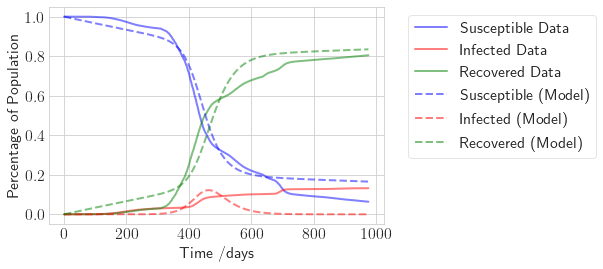

cost_without_lockdown: 1.3684268250096447


In [23]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu]
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma, optimal_nu = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, optimal_nu))
S, I, R = ret.T

plt.figure()
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time /days')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_fit_without_lockdown_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

cost_without_lockdown = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost_without_lockdown: {cost_without_lockdown}")

## SIRV Model with Lockdown

In [24]:
def deriv(y, t, N, beta, gamma, nu, lockdown):
    S, I, R = y
    t = min(int(t), len(lockdown) - 1)  # Ensure t is an integer and within the range of 'lockdown'
    dSdt = -beta * (1 - lockdown[int(t)]) * S * I / N - nu * S
    dIdt = beta * (1 - lockdown[int(t)]) * S * I / N - gamma * I
    dRdt = gamma * I + nu * S
    return dSdt, dIdt, dRdt

def integrate_system(params, y0, t, N, lockdown):
    beta, gamma, nu = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma, nu, lockdown))
    return result

def objective_function(params, y0, t, N, lockdown):
    predictions = integrate_system(params, y0, t, N, lockdown)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [27]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu = 0.4, 1/15, 0.01 
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

optimal_beta: 0.3782543035213969 optimal_gamma: 0.07767515435184538
optimal_beta/optimal_gamma: 4.869694906662396


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


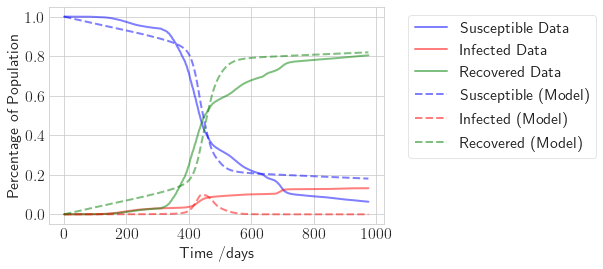

cost_with_lockdown: 1.4650604370467197


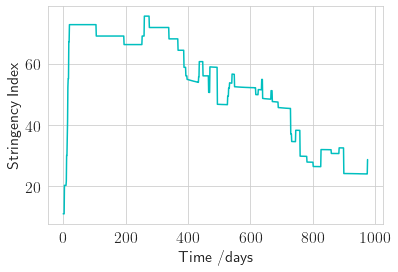

In [28]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu]
lockdown = list(df['stringency_index'].values / 100)
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N, lockdown),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma, optimal_nu = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, optimal_nu, lockdown))
S, I, R = ret.T

plt.figure()
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time /days')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_fit_with_lockdown_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

plt.plot(t, df['stringency_index'], 'c')
plt.xlabel('Time /days')
plt.ylabel('Stringency Index')
plt.grid(True)

cost_with_lockdown = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost_with_lockdown: {cost_with_lockdown}")

In [29]:
optimal_nu

0.0003626183507260282

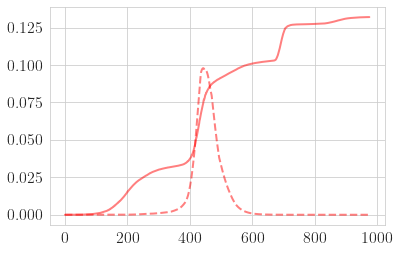

In [30]:
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')

## Decrease in cost by modelling Lockdown

In [ ]:
print(f"difference in cost for with/without lockdown: {cost_without_lockdown - cost_with_lockdown}")

In [ ]:
optimal_values = {
    'optimal_beta': optimal_beta,
    'optimal_gamma': optimal_gamma
}

with open(OPTIMAL_VALUES_FILE, "w") as outfile: 
    json.dump(optimal_values, outfile)

In [ ]:
print(df.columns)

In [ ]:
r0 = optimal_beta/optimal_gamma

df["S_modelled_with_lockdown"] = S
df["I_modelled_with_lockdown"] = I
df["R_modelled_with_lockdown"] = R
df["r_eff_modelled_with_lockdown"] = r0 * df["S_modelled_with_lockdown"]/df["N"]
df["r_eff_actual_with_lockdown"] = r0 * df["S"]/df["N"]

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(t, df['r_eff_actual_with_lockdown'], 'b', alpha=0.5, lw=2, label='R_eff actual')
plt.plot(t, df['r_eff_actual_without_lockdown'], 'b', alpha=0.5, lw=2, label='R_eff actual')
plt.plot(t, df['r_eff_modelled_with_lockdown'], 'r', alpha=0.5, lw=2, label='R_eff modelled with lockdown')
plt.plot(t, df['r_eff_modelled_without_lockdown'], 'g', alpha=0.5, lw=2, label='R_eff modelled without lockdown')
plt.legend()

In [ ]:
from scipy.spatial.distance import cosine
print(1 - cosine(df["r_eff_actual_without_lockdown"], df["r_eff_modelled_without_lockdown"]))
print(1 - cosine(df["r_eff_actual_with_lockdown"], df["r_eff_modelled_with_lockdown"]))

In [ ]:
stringency_data_points = np.arange(0, 100, 0.5)
fit_line_loaded = np.poly1d(np.load(STRINGENCY_BASED_GDP))
predicted_gdp = fit_line_loaded(stringency_data_points)
MIN_GDP = min(predicted_gdp)
MAX_GDP = max(predicted_gdp)

In [ ]:
df.columns

In [ ]:
print(max(df['gdp_normalized']), min(df['gdp_normalized']))

df['gdp_min_max_normalized'] = (df['gdp_normalized'] - MIN_GDP) / (MAX_GDP - MIN_GDP)
# here modelled means with gdp modelled with stringency
df['gdp_normalized_modelled_min_max_normalized'] =  (df['gdp_normalized_modelled'] - MIN_GDP) / (MAX_GDP - MIN_GDP)
df.to_csv(os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv"))

In [ ]:
plt.plot(df['gdp_min_max_normalized'])
plt.plot(df['gdp_normalized_modelled_min_max_normalized'])

In [ ]:
df.diff()['stringency_index'][1:].describe()

In [ ]:
df['stringency_index'].describe()

In [ ]:
actions_taken = []
# "output/actions_taken/-14154.05.txt"
with open("output/actions_taken/-4372.66.txt", "r") as f:
    for line in f:
        actions_taken.append(int(line.strip()))
start_stringency = 0.0
current_stringency_index = start_stringency
stringency_index_from_actions_taken = [current_stringency_index]
# stringency_index_from_actions_taken = []
diff_list = []
for action in actions_taken:
    reward_inertia_flag = False
    if action == 0:
        current_stringency_index = max(0, current_stringency_index - 10)
        diff = -10
    elif action == 1:
        current_stringency_index = max(0, current_stringency_index - 5)
        diff = -5
    elif action == 2:
        current_stringency_index = max(0, current_stringency_index - 2.5)
        diff = -2.5
    elif action == 3:
        current_stringency_index = max(0, current_stringency_index + 0)
        diff = 0
    elif action == 4:
        current_stringency_index = min(100, current_stringency_index + 2.5)
        diff = 2.5
    elif action == 5:
        current_stringency_index = min(100, current_stringency_index + 5)
        diff = 5
    elif action == 6:
        current_stringency_index = min(100, current_stringency_index + 10)
        diff = 10
    stringency_index_from_actions_taken.append(current_stringency_index)
    diff_list.append(diff)

# stringency_index_from_actions_taken = stringency_index_from_actions_taken + [0]
stringency_index_from_actions_taken = np.array(stringency_index_from_actions_taken)

# the below is a checking mechanism
# stringency_index_from_actions_taken = np.array([0] + list(df['stringency_index']))

In [ ]:
print(actions_taken[:10])

In [ ]:
def calculate_reward_weighted(gdp_normalized_list, r_eff_list):
    GDP_WEIGHT = 5 # change this value and see how it affects the reward
    reward = []
    for i in range(len(gdp_normalized_list)):
        if r_eff_list[i] > 1.5:
            # When r_eff > 1, the reward is more heavily influenced by the reduction in r_eff
            # print("before", gdp_normalized_list[i] / (5 * r_eff_list[i]))
            reward.append(gdp_normalized_list[i] / (5 * r_eff_list[i]))
        else:
            # When r_eff <= 1, the reward is more heavily influenced by the increase in GDP
            # print("after", GDP_WEIGHT * gdp_normalized_list[i])
            reward.append(GDP_WEIGHT * gdp_normalized_list[i])
    return reward

def reward_strategy(stringency_moves, reward_strategy_choosen, sir_technique):   
    N = df.loc[min(df.index), ['N']].item()
    y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
    days_difference = (max(df['date']) - min(df['date'])).days
    t = np.linspace(0, days_difference, days_difference + 1)
    
    stringency_index_random_choice = []
    store_S = np.zeros(days_difference + 1)
    store_I = np.zeros(days_difference + 1)
    store_R = np.zeros(days_difference + 1)

    # sir_technique 1 is faster
    # 2 is just to check whether the results match with 1
    moves_lockdown = stringency_index_from_actions_taken / 100
    if sir_technique == 1:
        moves_ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, moves_lockdown))
        moves_S, moves_I, moves_R = moves_ret.T

        df["S_moves"] = moves_S
        df["I_moves"] = moves_I
        df["R_moves"] = moves_R
    elif sir_technique == 2:
        for ith_day in range(days_difference + 1):
            stringency_index_random_choice.append(stringency_index_from_actions_taken[ith_day])
            t = np.linspace(0, ith_day, ith_day + 1)
            moves_ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, np.array(stringency_index_random_choice) / 100))
            moves_S, moves_I, moves_R = moves_ret.T
            store_S[ith_day] = moves_S[-1]
            store_I[ith_day] = moves_I[-1]
            store_R[ith_day] = moves_R[-1]
        df["S_moves"] = store_S
        df["I_moves"] = store_I
        df["R_moves"] = store_R
    
    df["r_eff_moves_with_lockdown"] = r0 * df["S_moves"]/df["N"]
    df["gdp_normalized_moves_min_max_normalized"] = ((fit_line_loaded(stringency_index_from_actions_taken) - MIN_GDP) / (MAX_GDP - MIN_GDP))[1:]
    
    modelled_ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, (df['stringency_index']) / 100))
    modelled_S, modelled_I, modelled_R = modelled_ret.T
    
    df["S_modelled_with_lockdown_inside_plot"] = modelled_S
    df["I_modelled_with_lockdown_inside_plot"] = modelled_I
    df["R_modelled_with_lockdown_inside_plot"] = modelled_R
    
    plt.figure(figsize=(10, 6))
    plt.plot(df["S_modelled_with_lockdown_inside_plot"], color='b', label='S_modelled')
    plt.plot(df["I_modelled_with_lockdown_inside_plot"], color='r', label='I_modelled')
    plt.plot(df["R_modelled_with_lockdown_inside_plot"], color='g', label='R_modelled')
    plt.plot(df["S_moves"], 'b--', label='S_moves')
    plt.plot(df["I_moves"], 'r--', label='I_moves')
    plt.plot(df["R_moves"], 'g--', label='R_moves')
    plt.xlabel('days')
    plt.ylabel('Population')
    plt.title('SIR_dynamics')
    plt.legend()
    plt.show()
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['stringency_index'], color='b', label='actual')
    plt.plot(stringency_index_from_actions_taken , color='g', label='moves')
    plt.xlabel('days')
    plt.ylabel('stringency')
    plt.title('stringency')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['r_eff_actual_with_lockdown'], color='b', label='actual')
    plt.plot(df['r_eff_modelled_with_lockdown'], color='r', label='modelled')
    plt.plot(df['r_eff_moves_with_lockdown'], color='g', label='moves')
    plt.xlabel('days')
    plt.ylabel('r_eff')
    plt.title('R_eff')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(df['gdp_min_max_normalized'], color='b', label='actual')
    plt.plot(df['gdp_normalized_modelled_min_max_normalized'], color='r', label='modelled')
    plt.plot(df['gdp_normalized_moves_min_max_normalized'], color='g', label='moves')
    plt.xlabel('days')
    plt.ylabel('gdp')
    plt.title('GDP')
    plt.legend()
    plt.show()
        
    if reward_strategy_choosen == 1:
        plt.figure(figsize=(10, 6))
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"], color='b', label='reward(actual) = {reward}'.format(reward = np.sum(df['gdp_min_max_normalized'] / df['r_eff_actual_with_lockdown'])))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"], color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(df['gdp_normalized_modelled_min_max_normalized'] / df['r_eff_modelled_with_lockdown'])))
        plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"], color='g', label='reward(modelled) = {reward}'.format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"])))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"], color='b', label='reward(actual) = {reward}'.format(reward = np.sum(df['gdp_min_max_normalized'] / df['r_eff_actual_with_lockdown'])))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"], color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(df['gdp_normalized_modelled_min_max_normalized'] / df['r_eff_modelled_with_lockdown'])))
        # plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"], color='g', label='reward(modelled) = {reward}'.format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"])))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
    if reward_strategy_choosen == 2:
        plt.figure(figsize=(10, 6))
        
        index_to_the_power_of = 0.001
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='b', label='reward(actual) = {reward}'.format(reward = np.sum(df['gdp_min_max_normalized'] / df['r_eff_actual_with_lockdown'] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(df['gdp_normalized_modelled_min_max_normalized'] / df['r_eff_modelled_with_lockdown'] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='g', label='reward(moves) = {reward}'.format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='b', label='reward(actual) = {reward}'.format(reward = np.sum(df['gdp_min_max_normalized'] / df['r_eff_actual_with_lockdown'] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(df['gdp_normalized_modelled_min_max_normalized'] / df['r_eff_modelled_with_lockdown'] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        # plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='g', label='reward(moves) = {reward}'.format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
    if reward_strategy_choosen == 3:
        
        # we need the epidemic to happen and also the I population to stay below a certain value (beds in the hospital) (10 multiple)
        # we need r_eff to be below 1 at an earlier stage (1 multiple)
        # we need to reward inertia by a small amount (0.1 multiple)
        
        hospital_capacity = 0.082
        hospital_capacity_reward = -100
        # reward_I_percentage = -100 if self.I_proportion >= 0.082 else 0
        I_reward_actual = [hospital_capacity_reward if I_percentage >= hospital_capacity else 0 for I_percentage in df["I"] / df["N"]]
        I_reward_modelled = [hospital_capacity_reward if I_percentage >= hospital_capacity else 0 for I_percentage in df["I_modelled_with_lockdown"] / N]
        I_reward_moves = [hospital_capacity_reward if I_percentage >= hospital_capacity else 0 for I_percentage in df["I_moves"] / N]
        
        r_eff_reward_choosen = 1
        r_eff_punishment_choosen = -1
        r_eff_level = 1.8
        r_eff_reward_actual = [r_eff_reward_choosen if r_eff <= r_eff_level else r_eff_punishment_choosen for r_eff in df["r_eff_actual_with_lockdown"]]
        r_eff_reward_modelled = [r_eff_reward_choosen if r_eff <= r_eff_level else r_eff_punishment_choosen for r_eff in df["r_eff_modelled_with_lockdown"]]
        r_eff_reward_moves = [r_eff_reward_choosen if r_eff <= r_eff_level else r_eff_punishment_choosen for r_eff in df["r_eff_moves_with_lockdown"]]
        
        inertia_rewards_actual = [0] + [abs(diff)*2*-1 for diff in (df['stringency_index'][i] - df['stringency_index'][i - 1] for i in range(1, len(df)))]
        # modelled reward for intertia is same as actual
        inertia_rewards_modelled = [0] + [abs(diff)*2*-1 for diff in (df['stringency_index'][i] - df['stringency_index'][i - 1] for i in range(1, len(df)))]
        inertia_rewards_moves = [abs(diff)*2*-1 for diff in (stringency_index_from_actions_taken[i] - stringency_index_from_actions_taken[i - 1] for i in range(1, len(stringency_index_from_actions_taken)))]
        
        # index_to_the_power_of = 0.00001
        # reward_actual = (df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of)) + I_reward_actual + r_eff_reward_actual + inertia_rewards_actual
        # reward_modelled = (df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of)) + I_reward_modelled + r_eff_reward_modelled + inertia_rewards_modelled
        # reward_moves = (df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of)) + I_reward_moves + r_eff_reward_moves + inertia_rewards_moves
        
        # TODO try this...
        """
        def calculate_reward(gdp_normalized, r_eff_actual):
            GDP_WEIGHT = 0.35 # change this value and see how it affects the reward
            if r_eff_actual > 1:
                # When r_eff > 1, the reward is more heavily influenced by the reduction in r_eff
                return gdp_normalized / (5 * r_eff_actual)
            else:
                # When r_eff <= 1, the reward is more heavily influenced by the increase in GDP
                return GDP_WEIGHT * gdp_normalized
        """
        
        reward_actual = calculate_reward_weighted(df["gdp_min_max_normalized"], df["r_eff_actual_with_lockdown"]) + I_reward_actual + r_eff_reward_actual + inertia_rewards_actual
        reward_modelled = calculate_reward_weighted(df["gdp_normalized_modelled_min_max_normalized"], df["r_eff_modelled_with_lockdown"]) + I_reward_modelled + r_eff_reward_modelled + inertia_rewards_modelled
        reward_moves = calculate_reward_weighted(df["gdp_normalized_moves_min_max_normalized"], df["r_eff_moves_with_lockdown"]) + I_reward_moves + r_eff_reward_moves + inertia_rewards_moves
        
        rl_reward_moves = reward_moves
        rl_reward_weighted = calculate_reward_weighted(df["gdp_normalized_moves_min_max_normalized"], df["r_eff_moves_with_lockdown"])
        rl_reward_I_percentage = I_reward_moves
        rl_reward_r_eff = r_eff_reward_moves
        rl_reward_inertia = inertia_rewards_moves

        plt.plot(reward_actual, color='b', label='reward(actual) = {reward}'.format(reward = np.sum(reward_actual)))
        plt.plot(reward_modelled, color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(reward_modelled)))
        plt.plot(reward_moves, color='g', label='reward(moves) = {reward}'.format(reward = np.sum(reward_moves)))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
        return rl_reward_moves, rl_reward_weighted, rl_reward_I_percentage, rl_reward_r_eff, rl_reward_inertia

In [ ]:
rl_reward_moves, rl_reward_weighted, rl_reward_I_percentage, rl_reward_r_eff, rl_reward_inertia = reward_strategy(stringency_index_from_actions_taken, reward_strategy_choosen=3, sir_technique=1)

In [ ]:
for I in df["I_modelled_with_lockdown"] / N:
    if I > 0.08:
        print("yes - 0.08")

for I in df["I_modelled_with_lockdown"] / N:
    if I > 0.10:
        print("yes - 0.10")

In [ ]:
print(max(df["I"] / df["N"]))

In [ ]:
print(max(df["I_modelled_with_lockdown"] / df["N"]))

## Double checking Calculation

In [ ]:
# print(rl_reward_moves, rl_reward_I_percentage, rl_reward_r_eff, rl_reward_inertia, rl_reward_weighted)

info_saved_df = pd.read_csv("output/info_save/-14233.67.csv")
for i in range(0, 1033):
    print(rl_reward_inertia[i], info_saved_df.iloc[i]['reward_inertia'])

In [ ]:
print("inside_rl:", np.sum(info_saved_df['reward_inertia']), "outside_rl:", np.sum(rl_reward_inertia))

plt.figure(figsize=(10, 6))
plt.plot(list(info_saved_df['reward_inertia'][200:350]), 'r', label='inside_rl')
plt.plot(list(rl_reward_inertia[200:350]), 'g', label='outside_rl')
plt.legend()

In [ ]:
plt.plot(info_saved_df['stringency_index'][:150], 'r', label='inside_rl')
plt.plot(stringency_index_from_actions_taken[:150], 'g', label='outside_rl')
plt.legend()

In [ ]:
print("inside_rl:", np.sum(info_saved_df['reward_r_eff']), "outside_rl:",  np.sum(rl_reward_r_eff))
plt.plot(info_saved_df['reward_r_eff'][:250], 'r', label='inside_rl')
plt.plot(rl_reward_r_eff[:250], 'g', label='outside_rl')
plt.legend()

In [ ]:
print("inside_rl:", np.sum(info_saved_df['reward_I_percentage']), "outside_rl:", np.sum(rl_reward_I_percentage))
plt.plot(info_saved_df['reward_I_percentage'][:200], 'r', label='inside_rl')
plt.plot(rl_reward_I_percentage[:200], 'g', label='outside_rl')

In [ ]:
print("inside_rl:", np.sum(info_saved_df['reward_weigthed']), "outside_rl:", np.sum(rl_reward_weighted))
plt.plot(info_saved_df['reward_weigthed'][:200], 'r', label='inside_rl')
plt.plot(rl_reward_weighted[:200], 'g', label='outside_rl')